In [221]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from statsmodels.tsa.stattools import coint
from tqdm import tqdm

N = 200
CI = 0.05

files = []

path = "../data/everything/Stocks"

for file in os.listdir(path):
    if file.endswith(".txt") or file.endswith(".csv"):
        files.append(os.path.join(path, file))

In [170]:
def get_df(file):
    return pd.read_csv(file, parse_dates=["Date"], index_col="Date")

In [246]:
cleaned_files = []

for file in tqdm(files):
    try:
        temp = get_df(file)

        if "Close" not in temp.columns or temp.empty:
            continue
        else:
            cleaned_files.append(file)
    except Exception as e:
        continue

100%|██████████████████████████████████████████| 7195/7195 [00:09<00:00, 729.85it/s]


In [235]:
random_files = random.sample(cleaned_files, N)
coint_pairs = []

for i in tqdm(range(N - 1)):
    stock1 = random_files[i]
    stock1_data = get_df(stock1)

    for j in range(i + 1, N):
        stock2 = random_files[j]
        stock2_data = get_df(stock2)

        stock1_close, stock2_close = stock1_data["Close"], stock2_data["Close"]
        stock1_close, stock2_close = stock1_close.align(stock2_close, join="inner")
        stock1_close, stock2_close = stock1_close.dropna(), stock2_close.dropna()

        if len(stock1_close) < 100 or len(stock2_close) < 100:
            continue
        else:
            stock1_norm = stock1_close/stock1_close.iloc[0]
            stock2_norm = stock2_close/stock2_close.iloc[0]
    
            score, p, _ = coint(stock1_norm, stock2_norm)

            if p < CI:
                coint_pairs.append((stock1, stock2, p, score))

            

100%|█████████████████████████████████████████████| 199/199 [07:46<00:00,  2.35s/it]


In [321]:
coint_df = pd.DataFrame(sorted(coint_pairs, key=lambda x: x[2]), columns=["stock1", "stock2", "p-value", "score"])

coint_df

,stock1,stock2,p-value,score
0,../data/everything/Stocks/cms_b.us.txt,../data/everything/Stocks/brg_d.us.txt,1.686604e-12,-8.495500
1,../data/everything/Stocks/cms_b.us.txt,../data/everything/Stocks/vnla.us.txt,1.725515e-12,-8.491606
2,../data/everything/Stocks/cms_b.us.txt,../data/everything/Stocks/rexr_a.us.txt,2.909959e-12,-8.402300
3,../data/everything/Stocks/cms_b.us.txt,../data/everything/Stocks/blhy.us.txt,6.792462e-12,-8.257085
4,../data/everything/Stocks/resn.us.txt,../data/everything/Stocks/pn.us.txt,7.159485e-12,-8.248054
...,...,...,...,...
1478,../data/everything/Stocks/gim.us.txt,../data/everything/Stocks/krnt.us.txt,4.983277e-02,-3.337100
1479,../data/everything/Stocks/mei.us.txt,../data/everything/Stocks/peg.us.txt,4.988089e-02,-3.336722
1480,../data/everything/Stocks/resn.us.txt,../data/everything/Stocks/mind.us.txt,4.988806e-02,-3.336666
1481,../data/everything/Stocks/banfp.us.txt,../data/everything/Stocks/bbt.us.txt,4.990136e-02,-3.336561


In [331]:
coint_plots = random.sample(coint_pairs, 3)

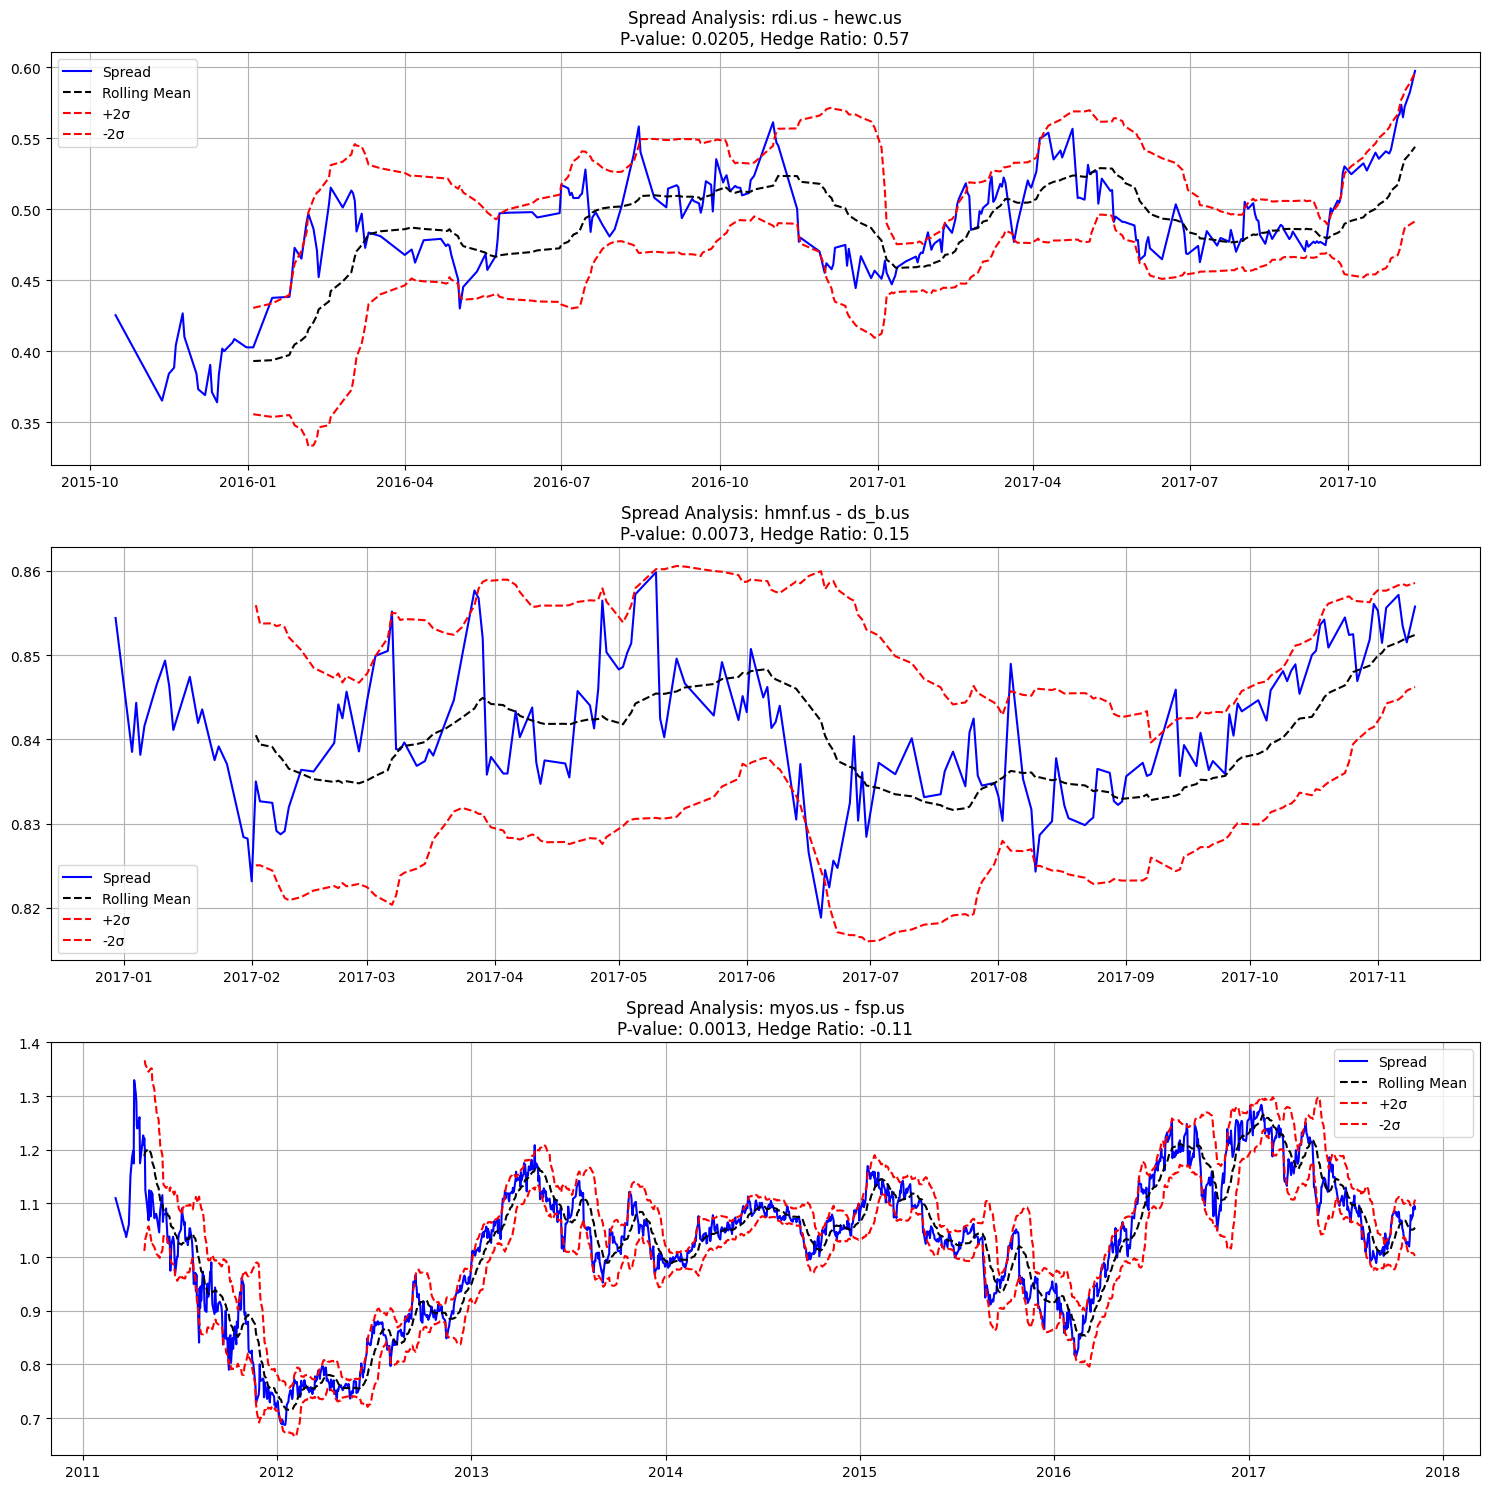

In [332]:
n_pairs = len(coint_plots)
fig, axes = plt.subplots(n_pairs, 1, figsize=(15, 5*n_pairs))
spread_stats = []
lookback_period = 20
trades = []

for i, (stock1, stock2, p, score) in enumerate(coint_plots):

    stock1_name, stock2_name = os.path.basename(stock1)[:-4], os.path.basename(stock2)[:-4]
    
    stock1, stock2 = get_df(stock1), get_df(stock2)

    stock1_close, stock2_close= stock1['Close'], stock2['Close']
    stock1_close, stock2_close = stock1_close.align(stock2_close, join='inner')

    stock1_norm = stock1_close / stock1_close.iloc[0]
    stock2_norm = stock2_close / stock2_close.iloc[0]
    

    hedge_ratio = np.polyfit(stock1_norm, stock2_norm, 1)[0]
    spread = (stock2_norm - (hedge_ratio * stock1_norm)).rename("spread")
    rolling_mean = spread.rolling(window=lookback_period).mean().rename("rolling_mean")
    rolling_std = spread.rolling(window=lookback_period).std().rename("rolling_std")
    z_score = ((spread - rolling_mean) / rolling_std).rename("z_score")

    spread_stats.append({
        'Pair': f'{stock1_name} - {stock2_name}',
        'Hedge Ratio': hedge_ratio,
        'Mean': rolling_mean.iloc[-1],
        'Std Dev': rolling_std.iloc[-1],
        'Current Z-score': z_score.iloc[-1],
        'Current Spread': spread.iloc[-1]
    })

    trade_actions = pd.concat([(rolling_mean + 2*rolling_std).rename("+2s"), (rolling_mean - 2*rolling_std).rename("-2s"), z_score], axis = 1).dropna()

    action = []
    
    for index, row in trade_actions.iterrows():
        z = row["z_score"]
        high = row["+2s"]
        low = row["-2s"]

        if z > high:
            action.append([index, f"SHORT {stock1_name}, LONG {stock2_name}"])
        elif z < low:
            action.append([index, f"LONG {stock1_name}, SHORT {stock2_name}"])

    actions = pd.DataFrame(action, columns = ["time", "action"]).set_index("time")
    trades.append(actions)

    axes[i].plot(spread.index, spread, label='Spread', color='blue')
    axes[i].plot(rolling_mean.index, rolling_mean, label='Rolling Mean', color='black', linestyle='--')
    axes[i].plot(rolling_mean.index, rolling_mean + 2*rolling_std, color='red', linestyle='--', label='+2σ')
    axes[i].plot(rolling_mean.index, rolling_mean - 2*rolling_std, color='red', linestyle='--', label='-2σ')
    
    # Add title and legend
    axes[i].set_title(f'Spread Analysis: {stock1_name} - {stock2_name}\nP-value: {p:.4f}, Hedge Ratio: {hedge_ratio:.2f}')
    axes[i].legend()
    axes[i].grid(True)
plt.tight_layout()
plt.show()


In [333]:
trades[0]

,action
time,
2016-01-04,"SHORT rdi.us, LONG hewc.us"
2016-01-15,"SHORT rdi.us, LONG hewc.us"
2016-01-25,"SHORT rdi.us, LONG hewc.us"
2016-01-26,"SHORT rdi.us, LONG hewc.us"
2016-01-28,"SHORT rdi.us, LONG hewc.us"
...,...
2017-11-01,"SHORT rdi.us, LONG hewc.us"
2017-11-02,"SHORT rdi.us, LONG hewc.us"
2017-11-03,"SHORT rdi.us, LONG hewc.us"
